### Checking precipitable water to get the first impression

In [1]:
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

In [2]:
# creatiing my own colormap
from matplotlib import cm
from matplotlib.colors import ListedColormap

viridis = cm.get_cmap('PRGn_r', 256)
newcolors = viridis(np.linspace(0,1,11))
maxcolor = np.array([3/256, 54/256, 130/256, 1])
mincolor = np.array([256/256, 256/256, 256/256, 1])
#newcolors[-1:, :] = maxcolor
newcolors[:1,:] = mincolor
newcmp = ListedColormap(newcolors)

In [3]:
opath='/project/meteo/w2w/B6/icon/naturerun-toy/spinnup/'
ofiles=['param','shallow','stochastic_shallow','explicit']

hist_bin=np.linspace(0,70,71)
yy=hist_bin[1:]+hist_bin[:-1]
yy=0.5*yy

#create the temporal evolution of PW distribution for the 40-km run
tqv_40km=xr.open_dataset(opath+'tqv-global1.nc')['tqv']
tqv_40km=tqv_40km.sel(lat=slice(-20.,20.))
nt_40km=tqv_40km.shape[0]
pw_freq_40km=np.zeros((nt_40km, 70))

for t in range(nt_40km):
    pw_freq_40km[t,:], bin_edges=np.histogram(tqv_40km[t,...], bins=hist_bin, density=True)

In [4]:
#create the temporal evolution of PW distribution for the 26-km run
tqv_26km=xr.open_dataset(opath+'tqv-global2.nc')['tqv']
tqv_26km=tqv_26km.sel(lat=slice(-20.,20.))
tqv_26km=tqv_26km.where(tqv_26km.time < np.datetime64('2020-07-31T00'), drop=True)
nt_26km=tqv_26km.shape[0]
pw_freq_26km=np.zeros((nt_26km, 70))

for t in range(nt_26km):
    pw_freq_26km[t,:], bin_edges=np.histogram(tqv_26km[t,...], bins=hist_bin, density=True)

In [5]:
#create the temporal evolution of PW distribution for the 13-km run
for i, od in enumerate(ofiles[:1]):
    tqv_13km=xr.open_dataset(opath+od+'/tqv.nc')['tqv']
    tqv_13km=tqv_13km.sel(lat=slice(-20.,20.))
    #not including the last time step
    #as this time step overlaps with the first time step of high-res runs
    tqv_13km=tqv_13km.where(tqv_13km.time < tqv_13km.time[-1], drop=True) 
    nt_13km=tqv_13km.shape[0]
    pw_freq_13km=np.zeros((nt_13km, 70))
    
    for t in range(nt_13km):
        pw_freq_13km[t,:], bin_edges=np.histogram(tqv_13km[t,...], bins=hist_bin, density=True)

In [7]:
#maybe better to run a bash script to create a single file?
tqv_5km=xr.open_dataset('data/tqv-5km-param.nc')['tqv']
tqv_5km=tqv_5km.sel(lat=slice(-20.,20.))
nt_5km=tqv_5km.shape[0]
pw_freq_5km=np.zeros((nt_5km, 70))

for t in range(nt_5km):
    pw_freq_5km[t,:], bin_edges=np.histogram(tqv_5km[t,...], bins=hist_bin, density=True)

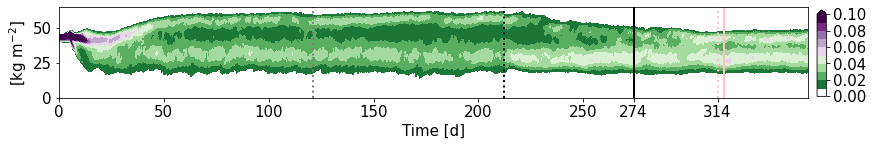

In [25]:
#plotting
fs = 15
plt.rcParams.update({'font.size': fs})

fig = plt.figure(figsize=(13,2))
plt.subplots_adjust(left=0.11, right=0.91, bottom=0.35, top=0.98)

#concatenate all arrays
pw_freq=np.concatenate((pw_freq_40km, pw_freq_26km, pw_freq_13km, pw_freq_5km), axis=0)
time=np.concatenate((tqv_40km.time, tqv_26km.time, tqv_13km.time, tqv_5km.time))
#initial time as day 0
time = time - np.datetime64('2020-01-01T00')
time = time.astype('float')
time = time*1e-9/86400.

im=plt.contourf(time,yy,pw_freq.transpose(), cmap=newcmp,
                levels=np.linspace(0,10,11)*0.01, extend='max')

plt.vlines(time[nt_40km+nt_26km],0, 70, color='black', linewidth=2, ls='dotted')
plt.vlines(time[nt_40km], 0, 70, color='gray',linewidth=2, ls='dotted')
plt.vlines(274, 0, 70, color='black', linewidth=2)
plt.vlines(time[nt_40km+nt_26km+nt_13km], 0, 70, color='pink',linewidth=2, ls='dotted')
plt.vlines(317, 0, 70, color='pink',linewidth=2)
plt.ylim(0,65)
plt.xticks([0,50,100,150,200,250,274,314])

plt.xlabel('Time [d]')
plt.ylabel('[kg m'+r'$^{-2}$'+']')
cbaxes = fig.add_axes([0.92, 0.36, 0.01, 0.6]) #[left, bottom, width, height]
cb=fig.colorbar(im,cax = cbaxes)
plt.savefig('../fig/pw_evolution.png', dpi=150)